Epoch 1/50
74/74 [==============================] - 5s 20ms/step - loss: 0.0306 - val_loss: 0.0022
Epoch 2/50
74/74 [==============================] - 1s 9ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 3/50
74/74 [==============================] - 1s 9ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 4/50
74/74 [==============================] - 1s 9ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 5/50
74/74 [==============================] - 1s 8ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 6/50
74/74 [==============================] - 1s 9ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 7/50
74/74 [==============================] - 1s 9ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 8/50
74/74 [==============================] - 1s 10ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 9/50
74/74 [==============================] - 1s 9ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 10/50
74/74 [==============================] - 1s 8ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 11/50
74/74

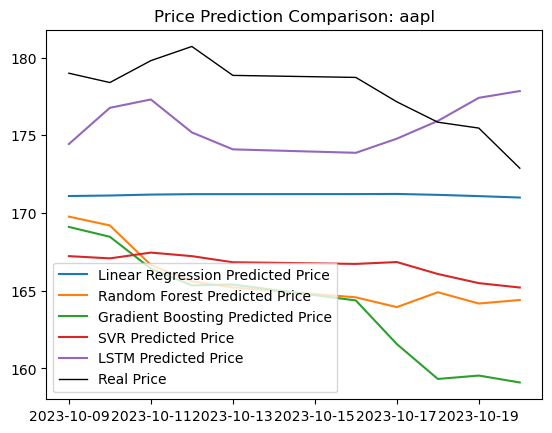

Real Prices: [178.99000549 178.38999939 179.80000305 180.71000671 178.8500061
 178.72000122 177.1499939  175.83999634 175.46000671 172.88000488]
Linear Regression Predicted Prices: [171.08939832 171.12397497 171.18306009 171.20969156 171.21126224
 171.21467662 171.22397802 171.16604004 171.08403121 170.99339461]
Random Forest Predicted Prices: [169.76548378 169.19847008 166.65475914 165.59852104 165.2099028
 164.57464523 163.94465996 164.90157822 164.17571617 164.40381607]
Gradient Boosting Predicted Prices: [169.10359487 168.46877744 166.42104732 165.34109111 165.39766123
 164.37355695 161.56898877 159.32416865 159.54172926 159.09694232]
SVR Predicted Prices: [167.22408057 167.08011887 167.45230628 167.22432321 166.83085284
 166.7236217  166.84323022 166.07590046 165.48747788 165.20523515]
LSTM Predicted Prices: [174.43591111 176.76458666 177.30128124 175.18233678 174.09212432
 173.87104572 174.77985797 175.92054034 177.4080254  177.843519  ]


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from datetime import datetime

def compute_rsi(data, window):
    delta = data.diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    
    roll_up = up.rolling(window=window).mean()
    roll_down = down.abs().rolling(window=window).mean()
    
    RS = roll_up / roll_down
    RSI = 100.0 - (100.0 / (1.0 + RS))
    
    return RSI

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# 下载股票数据
ticker_symbol = 'aapl'
ticker_data = yf.Ticker(ticker_symbol)
start_date = '2020-01-01'
end_date = '2023-10-01'
historical_data = ticker_data.history(start=start_date, end=end_date)
data = historical_data[['Close', 'Volume']].copy()

# 添加技术指标
data.loc[:, 'RSI'] = compute_rsi(data['Close'], 14)
data.loc[:, 'SMA'] = data['Close'].rolling(window=5).mean()
data.dropna(inplace=True)

# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# 使用滑动窗口法创建数据集
look_back = 10
X, y = create_dataset(data_scaled, look_back)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

# 创建和训练模型
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=24),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, random_state=24),
    "SVR": SVR(kernel='rbf', C=1e3, gamma=0.1),
    "LSTM": Sequential([
        LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
        Dropout(0.2),
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(25),
        Dense(1)
    ])
}
models["LSTM"].compile(optimizer='adam', loss='mean_squared_error')

# 训练模型
models["Linear Regression"].fit(X_train[:, -1, :], y_train)
models["Random Forest"].fit(X_train[:, -1, :], y_train)
models["Gradient Boosting"].fit(X_train[:, -1, :], y_train)
models["SVR"].fit(X_train[:, -1, :], y_train)
models["LSTM"].fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_test, y_test), verbose=1, shuffle=False)

# 获取真实的股价数据
real_data = ticker_data.history(start='2023-10-09', end=datetime.today().strftime('%Y-%m-%d'))
real_prices = real_data['Close'].values
num_points = min(len(real_prices), 10)
def predict_future(model, initial_input, steps, is_lstm=False):
    future_predictions = []
    current_input = initial_input.copy()
    
    for i in range(steps):
        if is_lstm:
            current_prediction = model.predict(current_input[np.newaxis, :, :])[0, 0]
            future_predictions.append(current_prediction)
            current_input = np.roll(current_input, -1, axis=0)
            current_input[-1, 0] = current_prediction
        else:
            current_prediction = model.predict(current_input[-1, :].reshape(1, -1))
            future_predictions.append(current_prediction[0])
            current_input = np.roll(current_input, -1, axis=0)
            current_input[-1, 0] = current_prediction[0]
    
    return future_predictions

# 预测股价
predictions = {}
for model_name, model in models.items():
    if model_name == "LSTM":
        predictions[model_name] = predict_future(model, data_scaled[-look_back:, :], num_points, is_lstm=True)
    else:
        predictions[model_name] = predict_future(model, data_scaled[-look_back:, :], num_points, is_lstm=False)
    
    predicted_prices = scaler.inverse_transform(np.hstack([np.array(predictions[model_name]).reshape(-1, 1), np.zeros((len(predictions[model_name]), data.shape[1]-1))]))[:, 0]
    plt.plot(real_data.index[:num_points], predicted_prices, label=f'{model_name} Predicted Price')

# 绘制真实股价
plt.plot(real_data.index[:num_points], real_prices[:num_points], label='Real Price', color='black', linewidth=1)
plt.legend()
plt.title(f'Price Prediction Comparison: {ticker_symbol}')
plt.show()

# 打印真实价格和预测价格
print(f"Real Prices: {real_prices[:num_points]}")
for model_name, prediction in predictions.items():
    predicted_prices = scaler.inverse_transform(np.hstack([np.array(prediction).reshape(-1, 1), np.zeros((len(prediction), data.shape[1]-1))]))[:, 0]
    print(f"{model_name} Predicted Prices: {predicted_prices}")
